In [ ]:
from google_research_trimap.trimap import trimap
import trimap_og
import umap
import json

import jax.random as random
from sklearn.datasets import fetch_openml, make_s_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
key = random.PRNGKey(42)

In [ ]:
# # Load the MNIST dataset
# mnist = fetch_openml('mnist_784', version=1)
# X, y = mnist['data'], mnist['target']

In [ ]:
filename = "mammoth_3d.json"
filename_targets = "mammoth_umap.json"
# read json
with open(filename, 'r') as f:
    mammoth = json.load(f)
print(mammoth[:2])
with open(filename_targets, 'r') as f:
    mammoth_filename_targets = json.load(f)
# mammoth_filename_targets = mammoth_filename_targets['labels']

In [ ]:
print(len(mammoth_filename_targets))

In [ ]:
X = mammoth_filename_targets['projections']['n=3,d=0.0']
y = mammoth_filename_targets['labels']

In [ ]:
# plot X in color y
plt.figure(figsize=(3, 3))
plt.scatter(
    [x[0] for x in X],
    [x[1] for x in X],
    c=y,
    s=1,
    alpha=0.5,
)


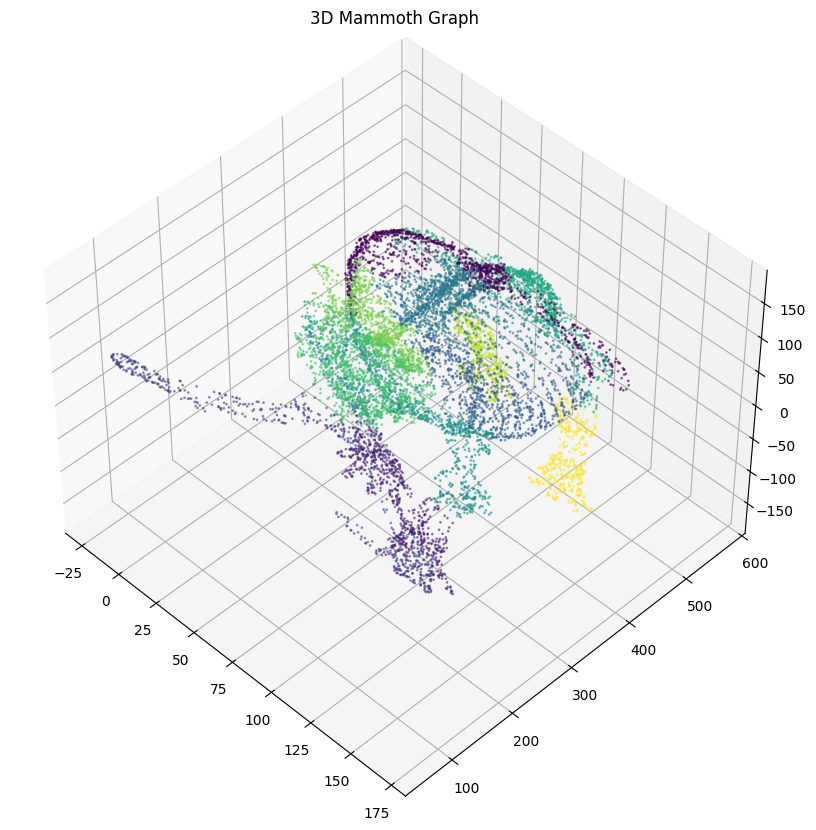

In [77]:
%matplotlib inline
# 3d graph of the mammooth with its targets
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    [x[0] for x in mammoth_filename_targets['3d']],
    [x[1] for x in mammoth_filename_targets['3d']],
    [x[2] for x in mammoth_filename_targets['3d']],
    c=mammoth_filename_targets['labels'],
    s=1,
    alpha=0.5,
)
plt.title("3D Mammoth Graph")
# view 
ax.view_init(elev=45, azim=-45)
plt.show()

In [ ]:
s_curve = make_s_curve(500, noise=0)

In [ ]:
print(len(mammoth))

In [78]:
X = np.array(mammoth_filename_targets['3d'])
y = np.array(mammoth_filename_targets['labels'])
# X = np.array(s_curve[0])
# y = np.array(s_curve[1])

In [83]:
%%time
embedding_trimap = trimap.transform(key, X, auto_diff=False, output_metric='squared_euclidean', lr=10)

CPU times: user 2min 25s, sys: 16.5 s, total: 2min 41s
Wall time: 1min 41s


In [84]:
%%time
embedding_trimap_ad = trimap.transform(key, X, auto_diff=True, output_metric='squared_euclidean', lr=10)

CPU times: user 1min 46s, sys: 5.63 s, total: 1min 52s
Wall time: 1min 24s


In [81]:
%%time
embedding_trimap_og = trimap_og.transform(key, X)

CPU times: user 1min 33s, sys: 4.93 s, total: 1min 38s
Wall time: 1min 7s


In [ ]:
# %%time
# embedding_umap = np.load("embedding_umap.npy")
# embedding_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
# np.save("embedding_umap.npy", embedding_umap)

In [ ]:
# %%time
# # embedding_tsne = np.load("embedding_tsne.npy")
# embedding_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
# np.save("embedding_tsne.npy", embedding_tsne)

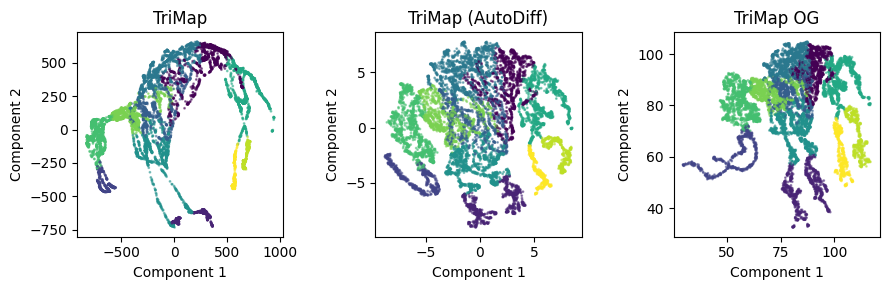

In [85]:
# Assuming trimap, trimap_ad, umap, and tsne are already computed
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# Plot trimap
axes[0].scatter(embedding_trimap[:, 0], embedding_trimap[:, 1], s=1, alpha=0.5, c=y, cmap='viridis')
axes[ 0].set_title("TriMap")
axes[ 0].set_xlabel("Component 1")
axes[ 0].set_ylabel("Component 2")

# Plot trimap_ad
axes[ 1].scatter(embedding_trimap_ad[:, 0], embedding_trimap_ad[:, 1], s=1, alpha=0.5, c=y, cmap='viridis')
axes[ 1].set_title("TriMap (AutoDiff)")
axes[ 1].set_xlabel("Component 1")
axes[ 1].set_ylabel("Component 2")

# Plot trimap_og
axes[ 2].scatter(embedding_trimap_og[:, 0], embedding_trimap_og[:, 1], s=1, alpha=0.5, c=y, cmap='viridis')
axes[ 2].set_title("TriMap OG")
axes[ 2].set_xlabel("Component 1")
axes[ 2].set_ylabel("Component 2")

# # Plot umap
# axes[1, 0].scatter(embedding_umap[:, 0], embedding_umap[:, 1], s=1, alpha=0.5)
# axes[1, 0].set_title("UMAP")
# axes[1, 0].set_xlabel("Component 1")
# axes[1, 0].set_ylabel("Component 2")
# 
# # Plot tsne
# axes[1, 1].scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], s=1, alpha=0.5)
# axes[1, 1].set_title("t-SNE")
# axes[1, 1].set_xlabel("Component 1")  
# axes[1, 1].set_ylabel("Component 2")

# Adjust layout
plt.tight_layout()
plt.show()

In [107]:
lr=10
init_embedding='random'

In [108]:
%%time
# trimap autodiff save plot every 10 frames
embeddings_trimap = trimap.transform(key, X, auto_diff=True, output_metric='squared_euclidean', export_iters=True, init_embedding=init_embedding, lr=lr, n_iters=1000)

CPU times: user 3min 38s, sys: 9.11 s, total: 3min 47s
Wall time: 2min 51s


In [109]:
#save every 10th embedding as a plot
# make directory mammoth_trimap_autodiff_squared_euclidean
dir_name = f"mammoth_trimap_autodiff_squared_euclidean_lr{lr}_{init_embedding}" 
import os
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
for i, embedding in enumerate(embeddings_trimap):
    if i % 10 == 0:
        plt.figure(figsize=(3, 3))
        plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=y,
            s=1,
            alpha=0.5,
        )
        plt.savefig(f"{dir_name}/iteration_{i}.png")
        plt.close()

In [115]:
# animate the frames from dir_name into a gif
import imageio
def create_gif_from_images(image_folder, output_gif):
    images = []
    for filename in sorted(os.listdir(image_folder)):
        if not filename.endswith(".png"):
            continue
        # global path
        filename = os.path.join(image_folder, filename)
        images.append(imageio.imread(filename))
    imageio.mimsave(output_gif, images, duration=0.1)
# Create the GIF
print(dir_name)
create_gif_from_images(dir_name, f"{dir_name}/animation.gif")

mammoth_trimap_autodiff_squared_euclidean_lr10_random


/var/folders/7j/t637n5s152v8xkcp4fd5tpm80000gn/T/ipykernel_44652/1269749965.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
